In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import initializers

# Height: в 1 дюйме 2,54 см
# Weight: в 1 фунте 0,453 кг

In [2]:
dataset = pd.read_csv("weight-height.csv") 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Height  10000 non-null  float64
 1   Weight  10000 non-null  float64
dtypes: float64(2)
memory usage: 156.4 KB


In [3]:
X_1 = dataset.iloc[:, 0].values
X_2 = dataset.iloc[:, 1].values
X = np.column_stack((X_1, X_2)) 
print(X)

[[ 73.84701702 241.89356318]
 [ 68.78190405 162.31047252]
 [ 74.11010539 212.74085556]
 ...
 [ 63.86799221 128.47531878]
 [ 69.03424313 163.85246135]
 [ 61.94424588 113.64910268]]


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=0)
print(X_train)

[[ 59.36813918 118.76451826]
 [ 63.91657834 156.77858596]
 [ 73.07534485 211.11480969]
 ...
 [ 67.46708591 162.47595732]
 [ 62.12748011 136.78302236]
 [ 70.59702452 188.45067415]]


In [5]:
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

random_dim = 2

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(2, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator
    
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=2, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [6]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=(random_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [7]:
def saveModels(epoch, generator, discriminator, examples=50):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    
#     fake_to_height = np.random.normal(65, 20, size=[100, 1])
#     fake_to_weight = np.random.normal(150, 130, size=[100, 1])
#     fake = np.column_stack((fake_to_height, fake_to_weight))
    
    generatedImages = generator.predict(noise)
    for i in range(generatedImages.shape[0]):
        print(np.column_stack((generatedImages[i], noise[i])))
        
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

In [8]:
dLosses = []
gLosses = []

def train(epochs=1, batch_size=100):
    batch_count = X_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batch_count))):
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            
#             fake_to_height = np.random.normal(65, 20, size=[batch_size, 1])
#             fake_to_weight = np.random.normal(150, 150, size=[batch_size, 1])
#             fake = np.column_stack((fake_to_height, fake_to_weight))
            
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            # Generate fake images
            generated_images = generator.predict(noise)
            z = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(z, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            
#             fake_to_height = np.random.normal(65, 20, size=[batch_size, 1])
#             fake_to_weight = np.random.normal(150, 130, size=[batch_size, 1])
#             fake = np.column_stack((fake_to_height, fake_to_weight))
            
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, y_gen)
            
        dLosses.append(dloss)
        gLosses.append(gloss)
            
        if e == 1 or e % 20 == 0:
            saveModels(e, generator, discriminator)


In [9]:
 train(160, 200)

  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 40/40 [00:08<00:00,  4.82it/s]


[[0.85126424 0.38906287]
 [0.9951489  1.24868428]]
[[0.69753706 0.4226736 ]
 [0.96682298 0.08145294]]
[[ 0.75442088  0.3054785 ]
 [ 0.97992092 -0.59326032]]
[[ 0.90751129  1.38408313]
 [ 0.99835318 -1.0790213 ]]
[[0.79113322 0.88788252]
 [0.98774159 0.01235598]]
[[ 0.93039739 -1.13467957]
 [ 0.99918836  1.64663908]]
[[ 0.81547177  0.69689151]
 [ 0.99060619 -0.73254095]]
[[ 0.94716322 -1.9649993 ]
 [ 0.99954271  0.83820601]]
[[ 0.87938797 -0.77714051]
 [ 0.99687868  1.227073  ]]
[[ 0.81853467  0.19361296]
 [ 0.99056816 -0.96777227]]
[[ 0.89490044 -1.0168645 ]
 [ 0.99745077 -1.0874916 ]]
[[0.89816076 0.64308057]
 [0.9981603  1.59814551]]
[[ 0.92243868 -1.63034631]
 [ 0.99876273 -0.56249971]]
[[ 0.9584657  -1.3403589 ]
 [ 0.99971271 -1.94222669]]
[[0.84372145 0.79457596]
 [0.99440956 0.99588074]]
[[0.82115775 0.01436085]
 [0.99196422 1.06457963]]
[[ 0.73166311  0.30714945]
 [ 0.97485322 -0.46960633]]
[[ 0.85422146  0.4494731 ]
 [ 0.99456954 -1.14312417]]
[[0.87742555 0.07826705]
 [0.99698

  2%|▎         | 1/40 [00:00<00:04,  8.46it/s]

--------------- Epoch 2 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.64it/s]

--------------- Epoch 3 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.34it/s]

--------------- Epoch 4 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.34it/s]

--------------- Epoch 5 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.61it/s]

--------------- Epoch 6 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.18it/s]

--------------- Epoch 11 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 12 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.47it/s]

--------------- Epoch 13 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 14 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 15 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.25it/s]

--------------- Epoch 16 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.96it/s]

--------------- Epoch 17 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.13it/s]

--------------- Epoch 18 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.50it/s]

--------------- Epoch 19 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.59it/s]

--------------- Epoch 20 ---------------


100%|██████████| 40/40 [00:07<00:00,  5.53it/s]


[[0.94933718 1.36379724]
 [1.         0.13198236]]
[[0.95755529 0.57801934]
 [1.         0.65499093]]
[[0.97291434 0.82133959]
 [1.         1.27205325]]
[[ 0.93850631 -0.08407462]
 [ 0.99999934 -0.46268619]]
[[ 0.95769441 -0.29603414]
 [ 1.          0.46016399]]
[[ 0.9310745   0.33777174]
 [ 0.99999905 -0.51409035]]
[[0.94931757 1.01799829]
 [1.         0.25731915]]
[[ 0.93376875  1.95068767]
 [ 0.99999952 -1.05897406]]
[[0.95865142 0.75660596]
 [1.         0.66706716]]
[[0.97108364 0.90222007]
 [1.         1.16796687]]
[[ 0.98879886 -2.5213144 ]
 [ 1.         -0.15448044]]
[[ 0.93488985  0.8891229 ]
 [ 0.99999911 -0.18149786]]
[[ 0.92746693  1.66135318]
 [ 0.99999917 -1.17612019]]
[[0.96321267 0.26985496]
 [1.         0.88272776]]
[[0.97105306 1.56667898]
 [1.         0.9571393 ]]
[[0.9666065  0.0781609 ]
 [1.         0.99451874]]
[[ 0.97455305 -1.54197466]
 [ 1.         -0.46460524]]
[[0.94569093 0.19989851]
 [0.99999964 0.18384597]]
[[0.94910526 1.35373316]
 [1.         0.12860271]]

  2%|▎         | 1/40 [00:00<00:06,  5.97it/s]

--------------- Epoch 21 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.43it/s]

--------------- Epoch 22 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.26it/s]

--------------- Epoch 23 ---------------


  2%|▎         | 1/40 [00:00<00:05,  6.78it/s]

--------------- Epoch 24 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.83it/s]

--------------- Epoch 25 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.50it/s]

--------------- Epoch 26 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 27 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.08it/s]

--------------- Epoch 28 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.02it/s]

--------------- Epoch 29 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.61it/s]

--------------- Epoch 30 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.77it/s]

--------------- Epoch 31 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.75it/s]

--------------- Epoch 32 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.44it/s]

--------------- Epoch 33 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 34 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.62it/s]

--------------- Epoch 35 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.50it/s]

--------------- Epoch 36 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.98it/s]

--------------- Epoch 37 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 38 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.55it/s]

--------------- Epoch 39 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.17it/s]

--------------- Epoch 40 ---------------


100%|██████████| 40/40 [00:07<00:00,  5.43it/s]


[[ 0.99994659 -0.09722916]
 [ 1.         -0.0139194 ]]
[[ 0.9999814  -0.6649391 ]
 [ 1.         -1.13422606]]
[[ 0.99998367 -1.12758506]
 [ 1.          0.52904258]]
[[ 0.99994725 -0.0855638 ]
 [ 1.          0.06349067]]
[[ 0.99999094 -0.46226106]
 [ 1.         -1.93206793]]
[[0.99997526 0.69298263]
 [1.         0.93036365]]
[[ 0.99997288 -0.4506391 ]
 [ 1.         -1.01623256]]
[[ 0.9999848  -0.48453361]
 [ 1.          1.30056676]]
[[ 0.9999662   0.77118205]
 [ 1.         -1.53370991]]
[[0.99997437 0.41218382]
 [1.         0.99878879]]
[[ 0.99995261 -0.19241126]
 [ 1.          0.24925085]]
[[ 0.99996448  0.14841719]
 [ 1.         -1.27170834]]
[[ 0.99995267  1.27421524]
 [ 1.         -0.75779443]]
[[ 0.99995762  0.89891435]
 [ 1.         -1.26615227]]
[[ 9.99981225e-01 -6.54614487e-05]
 [ 1.00000000e+00 -1.71923807e+00]]
[[0.99997252 1.56712213]
 [1.         0.11238782]]
[[ 0.99996382 -0.5657707 ]
 [ 1.          0.29181088]]
[[ 0.99993312  0.30698959]
 [ 1.         -0.23627562]]
[[ 0.9

  2%|▎         | 1/40 [00:00<00:05,  6.81it/s]

--------------- Epoch 41 ---------------


  2%|▎         | 1/40 [00:00<00:05,  6.72it/s]

--------------- Epoch 42 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.09it/s]

--------------- Epoch 43 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.29it/s]

--------------- Epoch 44 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 45 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 46 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.77it/s]

--------------- Epoch 47 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.63it/s]

--------------- Epoch 48 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 49 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 50 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.02it/s]

--------------- Epoch 51 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 52 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 53 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 54 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 55 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.70it/s]

--------------- Epoch 56 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 57 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.53it/s]

--------------- Epoch 58 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.46it/s]

--------------- Epoch 59 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.83it/s]

--------------- Epoch 60 ---------------


100%|██████████| 40/40 [00:07<00:00,  5.27it/s]


[[ 0.99999696  0.30204531]
 [ 1.         -1.26988376]]
[[ 0.9999997  -1.73886044]
 [ 1.         -1.04727256]]
[[ 0.99999905 -0.99247109]
 [ 1.         -1.14134537]]
[[ 0.9999972  -0.10912004]
 [ 1.          1.06012144]]
[[ 0.99999505  1.01739047]
 [ 1.         -0.2989726 ]]
[[ 0.99999881  1.24048047]
 [ 1.         -1.95080422]]
[[ 0.99999893 -0.60131887]
 [ 1.         -1.4699702 ]]
[[ 0.99999356  0.5858412 ]
 [ 1.         -0.36903839]]
[[ 0.99999428 -0.08801271]
 [ 1.          0.10071344]]
[[0.9999938  0.40045113]
 [1.         0.15133878]]
[[0.9999969  0.56995826]
 [1.         0.8034821 ]]
[[1.         1.64891033]
 [1.         2.49377108]]
[[ 0.99999607 -0.49776869]
 [ 1.         -0.62195056]]
[[0.99999356 0.3805011 ]
 [1.         0.0180614 ]]
[[0.9999944  0.04033707]
 [1.         0.391568  ]]
[[ 0.9999997  -0.27796504]
 [ 1.          2.2429593 ]]
[[0.99999964 1.00778045]
 [1.         1.89288942]]
[[ 1.         -2.22761111]
 [ 1.          0.14275239]]
[[ 0.99999404 -0.13395072]
 [ 1.  

  2%|▎         | 1/40 [00:00<00:06,  5.69it/s]

--------------- Epoch 61 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.26it/s]

--------------- Epoch 62 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 63 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.07it/s]

--------------- Epoch 64 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 65 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 66 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.31it/s]

--------------- Epoch 67 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 68 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.14it/s]

--------------- Epoch 69 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.62it/s]

--------------- Epoch 70 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 71 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 72 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.90it/s]

--------------- Epoch 73 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.48it/s]

--------------- Epoch 74 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 75 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 76 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.65it/s]

--------------- Epoch 77 ---------------


  2%|▎         | 1/40 [00:00<00:05,  6.69it/s]

--------------- Epoch 78 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.42it/s]

--------------- Epoch 79 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.00it/s]

--------------- Epoch 80 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

[[1.         2.34158687]
 [1.         1.04811306]]
[[0.99999958 1.29286181]
 [1.         0.57848867]]
[[ 0.99999976 -0.6290087 ]
 [ 1.         -1.31049466]]
[[ 0.9999994   0.58989164]
 [ 1.         -1.23716115]]
[[ 0.99999887  0.70492285]
 [ 1.         -0.54655589]]
[[ 1.         -1.06973331]
 [ 1.         -1.07513401]]
[[ 1.         -0.12930065]
 [ 1.         -2.3286584 ]]
[[0.99999952 1.49901927]
 [1.         0.00822144]]
[[ 0.99999881 -0.50776617]
 [ 1.         -0.02377381]]
[[ 0.99999893  0.14971691]
 [ 1.         -0.77315363]]
[[ 0.99999982  1.9320844 ]
 [ 1.         -0.55532606]]
[[ 0.99999863  0.00786406]
 [ 1.         -0.29905933]]
[[ 1.         -1.80788226]
 [ 1.         -0.00884087]]
[[0.99999923 1.15034339]
 [1.         0.16423255]]
[[ 0.99999952 -1.15471297]
 [ 1.          0.14839437]]
[[ 0.9999997  -1.40278878]
 [ 1.          0.18216905]]
[[ 0.99999964  0.32002475]
 [ 1.         -1.69075038]]
[[ 1.         -1.48643602]
 [ 1.         -1.32778299]]
[[ 1.         -2.89166389]

  2%|▎         | 1/40 [00:00<00:05,  6.64it/s]

--------------- Epoch 82 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.80it/s]

--------------- Epoch 83 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.71it/s]

--------------- Epoch 84 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.38it/s]

--------------- Epoch 85 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.46it/s]

--------------- Epoch 86 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.14it/s]

--------------- Epoch 87 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 88 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 89 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.24it/s]

--------------- Epoch 90 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.32it/s]

--------------- Epoch 91 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 92 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.74it/s]

--------------- Epoch 93 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 94 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 95 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 96 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 97 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 98 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.16it/s]

--------------- Epoch 99 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.60it/s]

--------------- Epoch 100 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

[[ 1.          1.02251365]
 [ 1.         -2.61715033]]
[[ 1.         -0.15259089]
 [ 1.          1.9296266 ]]
[[ 1.         -2.90545294]
 [ 1.         -0.13905948]]
[[ 0.99999952  0.74935842]
 [ 1.         -0.1980345 ]]
[[0.99999952 0.67001395]
 [1.         0.27922771]]
[[ 0.99999946  0.26814861]
 [ 1.         -0.51560084]]
[[0.99999934 0.17082084]
 [1.         0.22805214]]
[[ 0.99999964 -0.50852096]
 [ 1.          0.46843471]]
[[1.         2.89885701]
 [1.         1.1446023 ]]
[[ 0.9999997  -0.60031276]
 [ 1.          0.5100817 ]]
[[ 1.         -0.42969393]
 [ 1.          1.34428127]]
[[ 0.99999952 -0.19082566]
 [ 1.         -0.56638661]]
[[ 0.99999964  0.79965069]
 [ 1.         -0.63089959]]
[[ 0.99999952 -0.14698946]
 [ 1.         -0.19656562]]
[[ 1.          0.26506776]
 [ 1.         -1.55283737]]
[[ 0.99999964 -0.52854333]
 [ 1.          0.47565238]]
[[0.99999964 0.23027725]
 [1.         0.62259564]]
[[ 0.99999964 -0.85462506]
 [ 1.         -0.11944532]]
[[ 0.99999976 -0.52944982]

  2%|▎         | 1/40 [00:00<00:07,  5.43it/s]

--------------- Epoch 102 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 103 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 104 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.75it/s]

--------------- Epoch 105 ---------------


  2%|▎         | 1/40 [00:00<00:05,  7.36it/s]

--------------- Epoch 106 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.89it/s]

--------------- Epoch 107 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 108 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.21it/s]

--------------- Epoch 109 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 110 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.03it/s]

--------------- Epoch 111 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 112 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 113 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.72it/s]

--------------- Epoch 114 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.44it/s]

--------------- Epoch 115 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.44it/s]

--------------- Epoch 116 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.68it/s]

--------------- Epoch 117 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.14it/s]

--------------- Epoch 118 ---------------


  2%|▎         | 1/40 [00:00<00:05,  6.74it/s]

--------------- Epoch 119 ---------------


  2%|▎         | 1/40 [00:00<00:05,  6.72it/s]

--------------- Epoch 120 ---------------


100%|██████████| 40/40 [00:06<00:00,  5.83it/s]


[[1.         2.43145898]
 [1.         0.32935717]]
[[ 1.         -1.23041984]
 [ 1.         -0.43710851]]
[[1.         1.02173017]
 [1.         0.09383627]]
[[ 1.         -0.57412408]
 [ 1.         -0.78588601]]
[[ 0.9999997   0.55964004]
 [ 1.         -0.3530231 ]]
[[ 1.         -0.79025397]
 [ 1.          2.45106487]]
[[ 0.99999982  0.46005663]
 [ 1.         -0.0504939 ]]
[[ 0.99999964 -0.08052457]
 [ 1.         -0.32384174]]
[[ 1.         -0.74218654]
 [ 1.          1.4784668 ]]
[[1.         0.6701602 ]
 [1.         1.84725061]]
[[ 1.          0.31025274]
 [ 1.         -0.86479033]]
[[ 1.         -1.05008455]
 [ 1.         -1.55317905]]
[[ 1.          1.26409096]
 [ 1.         -1.76686889]]
[[ 1.         -0.04802503]
 [ 1.         -0.68749528]]
[[0.99999976 0.19966915]
 [1.         0.08808245]]
[[ 0.99999982 -0.34167819]
 [ 1.          0.28835589]]
[[ 1.         -0.70312618]
 [ 1.         -0.74324357]]
[[ 1.          1.26397114]
 [ 1.         -0.31375121]]
[[ 1.          0.21188279]

  2%|▎         | 1/40 [00:00<00:05,  7.57it/s]

--------------- Epoch 121 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.66it/s]

--------------- Epoch 122 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 123 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.50it/s]

--------------- Epoch 124 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 125 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 126 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.36it/s]

--------------- Epoch 127 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.86it/s]

--------------- Epoch 128 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 129 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 130 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 131 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 132 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 133 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.21it/s]

--------------- Epoch 134 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.45it/s]

--------------- Epoch 135 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.30it/s]

--------------- Epoch 136 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.17it/s]

--------------- Epoch 137 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 138 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 139 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.45it/s]

--------------- Epoch 140 ---------------


100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


[[ 1.          0.92111208]
 [ 1.         -0.20841128]]
[[1.         0.4525078 ]
 [1.         0.56574805]]
[[ 1.         -0.82715627]
 [ 1.          1.79385679]]
[[1.         0.08048596]
 [1.         1.54625583]]
[[1.         1.02068675]
 [1.         1.01040275]]
[[ 1.         -0.03347314]
 [ 1.          0.76970243]]
[[ 1.          1.22290545]
 [ 1.         -0.77926129]]
[[ 1.         -0.71704907]
 [ 1.          1.04065375]]
[[1.         0.33932206]
 [1.         0.68848106]]
[[ 1.          0.37099588]
 [ 1.         -0.67759826]]
[[ 1.          0.19481657]
 [ 1.         -0.41903277]]
[[ 1.         -2.29976773]
 [ 1.          0.29540366]]
[[ 1.         -1.4241573 ]
 [ 1.          0.09530584]]
[[1.         1.26706507]
 [1.         0.69214805]]
[[ 1.         -2.01143882]
 [ 1.          0.8459778 ]]
[[ 1.         -0.44507749]
 [ 1.         -1.98952193]]
[[ 1.         -1.94024683]
 [ 1.         -0.00829952]]
[[ 1.         -0.3830328 ]
 [ 1.          0.09038293]]
[[ 1.         -0.79908547]
 [ 

  2%|▎         | 1/40 [00:00<00:04,  8.26it/s]

--------------- Epoch 141 ---------------


  2%|▎         | 1/40 [00:00<00:06,  6.20it/s]

--------------- Epoch 142 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 143 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.99it/s]

--------------- Epoch 144 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.28it/s]

--------------- Epoch 145 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 146 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 147 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 148 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.16it/s]

--------------- Epoch 149 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 150 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 151 ---------------


  2%|▎         | 1/40 [00:00<00:06,  5.70it/s]

--------------- Epoch 152 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.31it/s]

--------------- Epoch 153 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 154 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 155 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 156 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.28it/s]

--------------- Epoch 157 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 158 ---------------


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 159 ---------------


  2%|▎         | 1/40 [00:00<00:07,  5.33it/s]

--------------- Epoch 160 ---------------


100%|██████████| 40/40 [00:07<00:00,  5.02it/s]


[[1.         1.30089942]
 [1.         0.04841483]]
[[ 1.          0.5409084 ]
 [ 1.         -1.29919401]]
[[ 1.         -0.44021719]
 [ 1.         -0.23254239]]
[[ 1.          0.38108288]
 [ 1.         -0.70830989]]
[[1.         0.6744786 ]
 [1.         1.24544592]]
[[ 1.         -0.25474387]
 [ 1.          0.10561622]]
[[1.        0.8779223]
 [1.        0.2064977]]
[[ 1.          0.60656461]
 [ 1.         -0.18957105]]
[[ 1.         -1.52484695]
 [ 1.          0.17898421]]
[[ 1.          1.4167542 ]
 [ 1.         -1.96485762]]
[[ 1.          1.25520748]
 [ 1.         -1.89042666]]
[[ 1.          0.09496786]
 [ 1.         -0.14323892]]
[[ 1.          2.27695388]
 [ 1.         -0.22136766]]
[[ 1.         -0.46764357]
 [ 1.          1.88151122]]
[[ 1.          0.20967482]
 [ 1.         -1.32159776]]
[[1.         1.53504684]
 [1.         0.28374443]]
[[1.         0.56922416]
 [1.         0.46703957]]
[[ 1.         -1.33032028]
 [ 1.         -1.03757938]]
[[ 1.         -0.2775511 ]
 [ 1.  

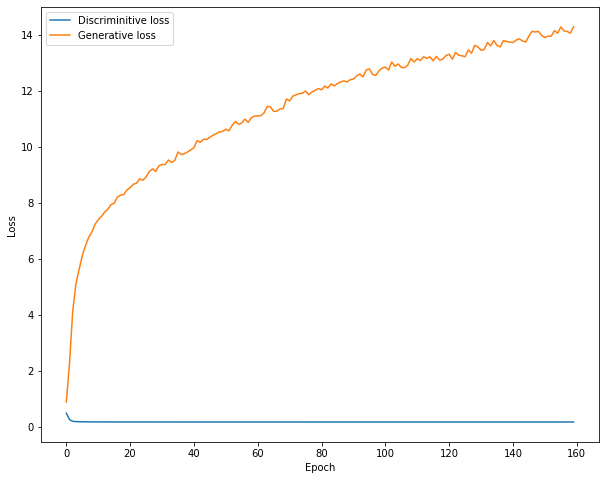

In [10]:
def plotLoss():
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
plotLoss()

In [12]:
from keras.models import load_model

model = load_model("models/gan_generator_epoch_160.h5")
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               768       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2

In [26]:
model = load_model("models/gan_discriminator_epoch_160.h5")

arr = np.array([[65, 180]])

print(model.predict(arr))

[[0.8726711]]
